# 採用課題　提出用モデル

## 準備

In [1]:
#!pip install wandb

In [2]:
import wandb

In [3]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: so-hamaguchi (so-hamaguchi-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torchvision.models import ResNet50_Weights
#import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR

In [5]:
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

以下で、ランダムシードの固定を行う。
シード値は４２とする。

最後のバックエンドの指示：

deterministicは計算の順番を固定化することで、計算のズレをなくすというもの。再現性を高める

benchmarkは計算アルゴリズムを固定化するもの。こちらも再現性を高める。

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cuda'

In [8]:
# ハイパーパラメータ一覧
# この部分を変更することで、ハイパラを変更できます。

config = {
    "learning_rate":1e-4,
    "batch_size": 256,
    "epochs": 12,
    "weight_decay": 1e-4,
    "architecture": "ResNet50",
    "dataset": "CIFAR-10",
    "optimizer": "Adam",
    "augmentation": "flip,crop,rotate",
    "note": "全層FT＋スケジューラ"
}

In [9]:
wandb.init(
    project="cifar10-resnet",
    name="model_for_submission6",
    config=config
)

## 画像データ前処理

まずここで、データの拡張を行って、過学習を抑える処置を行う。
エポックごとに違う加工がなされることにより、汎化性能が上がる

valデータの方が正解率が高くなったことから、データ拡張した画像が学習するには難しすぎたということが考えられるので、データ拡張の程度を少し弱める

transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),を削除。paddingを４→３へ、Rotationを10→５へ

**転移学習を導入する**

そのために前処理で画像を224にリサイズする。解像度を無理やりあげる。

なぜかというと、事前学習済みのResNetはImageNetというデータをつかって学習されているが、そのimagenetの解像度が224だから。

２２４＊２２４の画像を圧縮して特徴量をつかんでいるので、３２＊３２の画像をそのまま入力すると圧縮されすぎて特徴がつかめない事態に陥り、精度が出ない。

さらに、現代の多くの写真は解像度が高いので、こちらの方がより実用性もあるという点で、よりよい。

また、ResNet50はImageNetというデータセットで事前学習されているが、そこでは精度を上げるために、ImageNetの色の平均値を用いて正規化されている。

その正規化からずれてしまうと、凍結の場合はうまく精度が出ないのは理解できるし、ファインチューニングでもネットワーク中でズレがどんどん伝播してしまい学習しづらい。

そのため、imagenetの色平均値を用いて正規化を行う

解像度が高いので、バッチサイズを256に縮小。メモリがオーバーするのを防ぐ。

**学習に時間がかかりすぎた**

なぜか調べたところ、リサイズをCPUでやるのが重くてボトルネックになっていたっぽい

データ前処理をGPUに移す。さらに、バリデーションアキュラシーのほうが高かったことを鑑みて前処理を減らす。

**前処理は重要だった**

上記をしてもバリデーションaccが伸びなかった。別にバリデーションが高いことは、そこまで悪いことではないなと反省。前処理をもとにもどす。

**さらに悪化した**

なんで...？前処理してからリサイズだと何が何だか分からなくなるのかな。回転などの前処理もGPUに乗せてみる。
flipはリサイズ前後で変わらないのでそのまま。

**あんまり変わらなかった**
バッチサイズが原因なのか？256にもどす。

In [10]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root="./data", train = True, download=True, transform = train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train = False, download=True, transform = val_transform)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


In [11]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size = wandb.config.batch_size, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size = wandb.config.batch_size, shuffle=False, num_workers=2)

In [13]:
data_iter = iter(train_dataloader)

In [14]:
imgs, labels = next(data_iter)

In [15]:
labels

tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8,
        6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7,
        0, 1, 2, 3, 4, 6, 5, 9, 3, 5, 8, 8, 2, 6, 5, 0, 0, 2, 2, 0, 4, 4, 5, 2,
        8, 7, 4, 7, 2, 2, 0, 3, 9, 7, 9, 6, 6, 8, 4, 9, 4, 2, 6, 4, 3, 3, 6, 5,
        1, 1, 5, 0, 3, 0, 0, 7, 2, 3, 9, 3, 6, 8, 7, 9, 9, 1, 6, 2, 1, 4, 2, 9,
        5, 3, 0, 1, 8, 0, 7, 5, 5, 5, 7, 2, 3, 3, 5, 7, 2, 0, 3, 3, 3, 8, 5, 3,
        5, 8, 3, 7, 5, 7, 2, 3, 3, 3, 6, 1, 5, 9, 1, 6, 8, 7, 3, 0, 8, 0, 4, 8,
        1, 9, 3, 2, 8, 3, 7, 0, 8, 9, 2, 6, 8, 1, 8, 9, 2, 3, 0, 2, 1, 6, 3, 3,
        4, 4, 5, 3, 8, 9, 7, 6, 8, 6, 1, 8, 3, 9, 8, 6])

In [16]:
imgs.size()

torch.Size([256, 3, 32, 32])

In [17]:
img = imgs[0]

In [18]:
img_permute = img.permute(1,2,0)

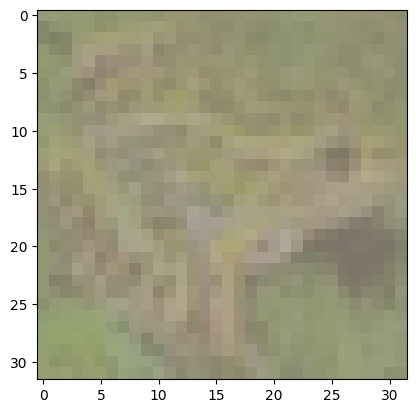

In [19]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img_show = img.permute(1, 2, 0).numpy() # HWCにしてnumpy化
img_show = std * img_show + mean
img_show = np.clip(img_show, 0, 1)    # 最後に0-1に収める

plt.imshow(img_show)

事前学習済みのモデルを導入する。

ファインチューニングさせる。

In [20]:
model = resnet50(weights=ResNet)

model.fc = nn.Linear(model.fc.in_features, 10)

In [21]:
"""

frozen_weights_path = "experiment_two-stage_base4.pth"

if os.path.exists(frozen_weights_path):
    print(f"🔄 Loading Best Seed from {frozen_weights_path}...")
    state_dict = torch.load(frozen_weights_path, map_location=device)
    model.load_state_dict(state_dict)
else:
    print("⚠️ Seed file not found!")

"""

🔄 Loading Best Seed from experiment_two-stage_base4.pth...


In [22]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

weight_decayというハイパーパラメータを追加。

これを行うことで、一点だけに重みが偏るみたいなことがないように、重みを大きくしないでほしいという抑制がかかる。

そうすると、本当に重要な部分（猫の耳とか）にのみ重みがつくようになる

過学習抑制の効果が期待できる。


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=wandb.config.epochs, eta_min=1e-6)

gpuで実行する前処理を追加

In [25]:
num_epochs = wandb.config.epochs

losses = []
accs = []
val_losses = []
val_accs = []

gpu_transform = nn.Sequential(
    transforms.Resize(224, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomCrop(224, padding=3),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
).to(device)

# 検証用
gpu_val_transform = nn.Sequential(
    transforms.Resize(224, antialias=True),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
).to(device)

for  epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  running_acc = 0.0
  for imgs, labels in  train_dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    imgs = gpu_transform(imgs)

    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    running_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    running_acc += torch.mean(pred.eq(labels).float())
    optimizer.step()

  scheduler.step()
  running_loss /= len(train_dataloader)
  running_acc /= len(train_dataloader)
  losses.append(running_loss)
  accs.append(running_acc)
#
#validation loop
#
  model.eval()
  val_running_loss = 0.0
  val_running_acc = 0.0

  all_preds = []
  all_labels = []
  misclassified_images = []

  for val_imgs, val_labels in validation_dataloader:
    val_imgs = val_imgs.to(device)
    val_labels = val_labels.to(device)

    val_imgs = gpu_val_transform(val_imgs)

    with torch.no_grad():
      val_output  = model(val_imgs)
      val_loss = criterion(val_output, val_labels)
    val_running_loss += val_loss.item()
    val_pred = torch.argmax(val_output, dim=1)
    val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    all_preds.extend(val_pred.cpu().numpy())
    all_labels.extend(val_labels.cpu().numpy())

    # 予測と正解が違う場所（インデックス）を探す
    mistakes = val_pred != val_labels

    # 間違えた画像のインデックスを取得
    mistake_indices = mistakes.nonzero(as_tuple=True)[0]

    # 間違えた画像をリストに追加（32枚集まったら終了）
    if len(misclassified_images) < 32:
      for idx in mistake_indices:
        if len(misclassified_images) >= 32: break

        img = val_imgs[idx].cpu().permute(1, 2, 0).numpy()
        pred_label = names[val_pred[idx].item()]
        true_label = names[val_labels[idx].item()]

        img = std * img + mean
        img = np.clip(img, 0, 1)

        # W&B用の画像データにしてリストに入れる
        misclassified_images.append(
        wandb.Image(img, caption=f"Pred: {pred_label}, True: {true_label}")
       )

  #precision,recall,f1の計算
  precision, recall, f1, _ = precision_recall_fscore_support(
      all_labels, all_preds, average='macro', zero_division=0
  )

  #混同行列作成
  cm = confusion_matrix(all_labels, all_preds)
  fig, ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names, ax=ax)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix (Epoch {epoch+1})')

  current_lr = scheduler.get_last_lr()[0]

  cm_image = wandb.Image(fig)
  plt.close(fig)

  val_running_loss /= len(validation_dataloader)
  val_running_acc /= len(validation_dataloader)
  val_losses.append(val_running_loss)
  val_accs.append(val_running_acc)
  print("epoch: {}, loss: {}, acc:{}, \
  val loss: {}, val acc: {}, F1: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc, f1))

  wandb.log({
      "epoch":epoch + 1,
      "lr": current_lr,
      "acc": running_acc,
      "loss": running_loss,
      "val acc": val_running_acc,
      "val loss": val_running_loss,
      "val precision": precision,
      "val recall": recall,
      "val f1": f1,
      "confusion_matrix": cm_image,
      "Misclassified Examples": misclassified_images
      })

run_name = wandb.run.name.replace(" ", "_")

torch.save(model.state_dict(), f"{run_name}.pth")
wandb.save(f"{run_name}.pth")

epoch: 1, loss: 0.21294170777712548, acc:0.9280571937561035,   val loss: 0.16198726799339055, val acc: 0.9473633170127869, F1: 0.9475386103738442
epoch: 2, loss: 0.0892135252586889, acc:0.9696667790412903,   val loss: 0.1220166296698153, val acc: 0.957714855670929, F1: 0.958216917687561
epoch: 3, loss: 0.0431793143174478, acc:0.9852280020713806,   val loss: 0.12917978465557098, val acc: 0.959667980670929, F1: 0.9601472684814901
epoch: 4, loss: 0.0235857922911682, acc:0.9922991394996643,   val loss: 0.1324109905399382, val acc: 0.9629883170127869, F1: 0.9636094047709645
epoch: 5, loss: 0.0149819809374428, acc:0.9948979616165161,   val loss: 0.12128740842454136, val acc: 0.96533203125, F1: 0.9644947410701187
epoch: 6, loss: 0.010147959754769025, acc:0.9968670010566711,   val loss: 0.11693175910040736, val acc: 0.9673828482627869, F1: 0.9681098028759694
epoch: 7, loss: 0.006877285078208305, acc:0.9979870915412903,   val loss: 0.1148955880664289, val acc: 0.969921886920929, F1: 0.970684112

['/content/wandb/run-20251129_071059-8js2j5zx/files/model_for_submission7.pth']

##評価

評価指標について

ROC-AUCは多クラス分類において説明が煩雑になるため、今回は見送り。

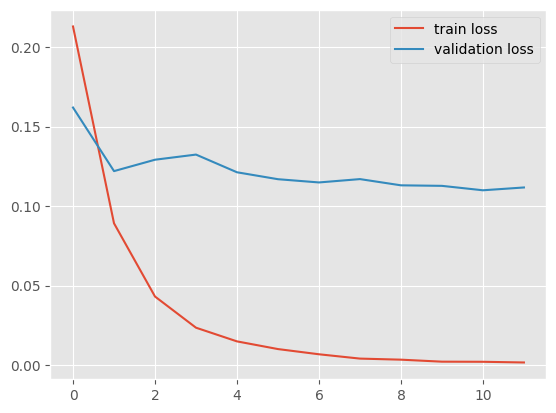

In [26]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

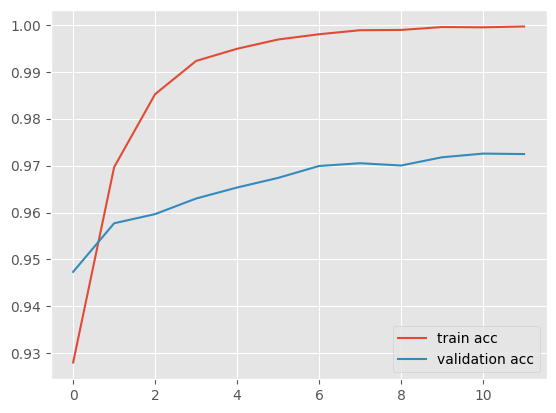

In [27]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.legend()

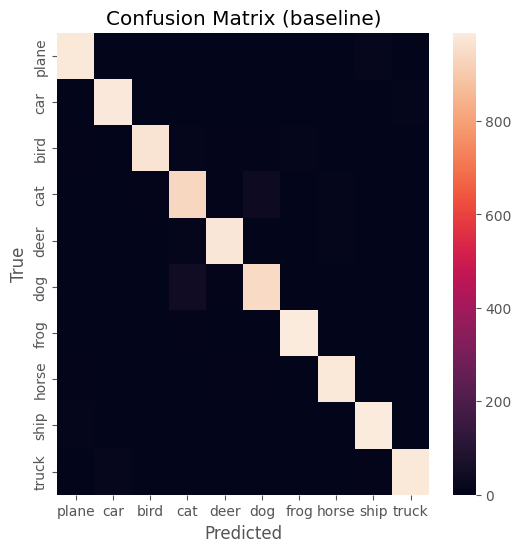

In [28]:
# 1. 全予測を集める
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in validation_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        # ★ここに追加！検証用の前処理を通す
        imgs = gpu_val_transform(imgs)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. 混同行列
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    xticklabels=names,
    yticklabels=names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (baseline)")
plt.show()


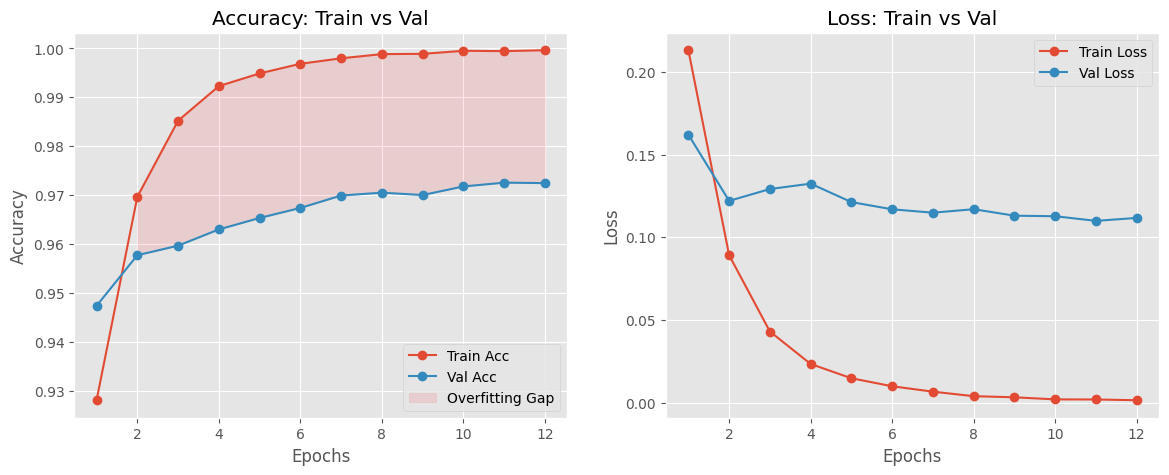

In [29]:
# データをCPUに移してリスト化（念のため）
train_acc_list = [x.item() if isinstance(x, torch.Tensor) else x for x in accs]
val_acc_list = [x.item() if isinstance(x, torch.Tensor) else x for x in val_accs]
train_loss_list = [x if isinstance(x, float) else x.item() for x in losses]
val_loss_list = [x if isinstance(x, float) else x.item() for x in val_losses]

epochs_range = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(14, 5))

# --- 精度 (Accuracy) の比較グラフ ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label='Train Acc', marker='o')
plt.plot(epochs_range, val_acc_list, label='Val Acc', marker='o')

# ★ここがポイント：ギャップを塗りつぶす
plt.fill_between(epochs_range, train_acc_list, val_acc_list, where=[t > v for t, v in zip(train_acc_list, val_acc_list)],
                 color='red', alpha=0.1, label='Overfitting Gap')

plt.title('Accuracy: Train vs Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# --- 損失 (Loss) の比較グラフ ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss_list, label='Val Loss', marker='o')
plt.title('Loss: Train vs Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

In [30]:
wandb.finish()

acc,▁▅▇▇████████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▂▂▁▁▁▁▁▁▁▁
lr,██▇▆▅▅▄▃▂▁▁▁
val acc,▁▄▄▅▆▇▇▇▇███
val f1,▁▄▅▆▆▇█▇▇███
val loss,█▃▄▄▃▂▂▂▁▁▁▁
val precision,▁▄▅▆▆▇█▇▇███
val recall,▁▄▅▆▆▇█▇▇███
acc,0.99964
epoch,12
